In [4]:
import sys
sys.path.append('/home/s/seanmacb/Camera/pkgs')
sys.path.append('/home/s/seanmacb/Camera/pkgs/eo_pipe/python/lsst/eo/pipe')
import eo_pipe.python.lsst.eo.pipe as eo_pipe
from eo_pipe.python.lsst.eo.pipe import (readNoiseTask, darkCurrentTask, defectsTask, eperTask, divisaderoTearingTask, ptcPlotsTask,linearityPlotsTask, bfAnalysisTask)
import run_six_utils as rsu
import myutils_ar.myutils as myu
import lsst.afw.display as afwDisplay
import lsst.daf.butler as daf_butler
afwDisplay.setDefaultBackend('matplotlib')
import matplotlib.pyplot as plt
import numpy as np
import lsst.afw.image as afwImage
from lsst.afw.image import Mask
import lsst.geom as geom
from matplotlib.lines import Line2D

## Take the defects in `df_dict`, and take difference of the same amps along defect columns

In [5]:
repo = 'embargo_new'
operator = 'lsstccs'
acq_runs = ['E1110',"E1880"]  # Run 6, run 6b.
weeklys = 'w_2024_35'
# Use this slice for now since the dark defects are complicated by the sensor edge effects
diff_columns = ['BRIGHT_COLUMNS', 'BRIGHT_PIXELS','DARK_COLUMNS', 'DARK_PIXELS'][0:2]
butler = daf_butler.Butler(repo)


In [6]:
butler.registry.queryCollections(f"u/lsstccs/*E1497*",collectionTypes=daf_butler.CollectionType.CHAINED)

['u/lsstccs/dark_E1497_w_2024_35',
 'u/lsstccs/eo_read_noise_E1497_w_2024_35',
 'u/lsstccs/eo_persistence_E1497_w_2024_35',
 'u/lsstccs/bias_E1497_w_2024_35',
 'u/lsstccs/eo_dark_current_E1497_w_2024_35',
 'u/lsstccs/eo_bf_analysis_E1497_w_2024_35',
 'u/lsstccs/eo_ptc_plots_E1497_w_2024_35',
 'u/lsstccs/eo_dark_defects_E1497_w_2024_35',
 'u/lsstccs/flat_E1497_w_2024_35',
 'u/lsstccs/eo_eper_E1497_w_2024_35',
 'u/lsstccs/defects_E1497_w_2024_35',
 'u/lsstccs/eo_linearity_plots_E1497_w_2024_35',
 'u/lsstccs/eo_divisadero_tearing_E1497_w_2024_35',
 'u/lsstccs/eo_bias_stability_E1497_w_2024_35',
 'u/lsstccs/eo_cti_vs_flux_E1497_w_2024_35',
 'u/lsstccs/eo_bias_shifts_E1497_w_2024_35',
 'u/lsstccs/ptc_E1497_w_2024_35',
 'u/lsstccs/eo_bright_defects_E1497_w_2024_35',
 'u/lsstccs/eo_raft_amp_correlations_E1497_w_2024_35',
 'u/lsstccs/eo_raft_calib_mosaics_E1497_w_2024_35',
 'u/lsstccs/eo_raft_lambda_mosaics_E1497_w_2024_35']

In [7]:
refList = list(butler.registry.queryDatasets("eo_flat",collections="u/lsstccs/eo_dark_defects_E1497_w_2024_35"))

for ref in refList:
    # eo_flat = butler.get(ref)
    # print(ref.dataId)
    print("'",ref.id,end="',",sep="")

'47154b4c-e914-41f8-be55-f9acd6ac177c','85f3c1bc-891a-4739-b8bd-5545fffc5854','2fc064f7-c80e-4418-b2bb-a13459dc60e8','12e8b8ed-57c5-4517-b0cd-f30f1308dd6c','92526c77-70b3-4832-b495-c661eddb5e49','3b67f708-36a8-42f5-95bb-15a3fb728de9','df6b7d8d-cda2-4301-961d-7fc19d88068d','1cd594d7-ff8d-4972-85b3-b9b2e6275a03','511bbd5c-3f97-4f60-aca1-7b73dddaa71c','5c59372f-23cd-4a8d-b1ca-c70881de492a','3f1020bc-9f49-4a62-8604-2d4b31b2adf0','05e15e3a-a79d-4b0f-87ef-2a195db1a87f','bfa9d015-633c-425e-8e78-4733ab3efc0d','3097f887-86ce-491f-9fa4-752bcc233d23','cf1bb478-900c-4a1f-a267-ffc411c3c7f5','c4071f9c-ef58-419a-bb95-9edf23f0fb46','b7e6f03c-b7e2-474b-9e34-73dec0ccd136','06277885-84b4-4be3-a3b3-a48a0485af19','9a36ab38-730b-42cb-bb61-19fdfceffdaa','9d43e0cd-2185-4554-ad01-d6724ba159ef','462b99ee-1970-4313-bf71-1b7fbb6ff095','58c4d29d-954a-411e-9d7e-f49dbbce91ad','986a7a6a-3b32-47de-8d73-3e0888895b7d','c0b07e21-4f24-4b8b-a5a7-3d44024f49d9','4732201d-d01f-4652-be4f-b66b0a45e169','f3985d30-f3d7-46c7-ac0c-

In [8]:
list(butler.registry.queryDimensionRecords("exposure",datasets='eo_flat',collections="u/lsstccs/eo_dark_defects_E1497_w_2024_35"))

[exposure.RecordClass(instrument='LSSTCam', id=2024101200206, day_obs=20241012, group='2024101200206', physical_filter='HIGH', obs_id='MC_C_20241012_000206', exposure_time=15.0, dark_time=15.0142, observation_type='flat', observation_reason='sflat_hi', seq_num=206, seq_start=206, seq_end=206, target_name='UNKNOWN', science_program='E1362', tracking_ra=None, tracking_dec=None, sky_angle=None, azimuth=None, zenith_angle=None, has_simulated=False, can_see_sky=None, timespan=Timespan(begin=astropy.time.Time(2460596.0, 0.17525402782484956, scale='tai', format='jd'), end=astropy.time.Time(2460596.0, 0.17542780092592591, scale='tai', format='jd'))),
 exposure.RecordClass(instrument='LSSTCam', id=2024101200225, day_obs=20241012, group='2024101200225', physical_filter='HIGH', obs_id='MC_C_20241012_000225', exposure_time=15.0, dark_time=15.0148, observation_type='flat', observation_reason='sflat_hi', seq_num=225, seq_start=225, seq_end=225, target_name='UNKNOWN', science_program='E1362', trackin

In [9]:
df_dict = {}
butler = daf_butler.Butler(repo)
for acq_run in acq_runs:
    # acq_run,weekly = acq_runs[run_iter],weeklys[run_iter]
    collection = butler.registry.queryCollections(f"u/{operator}/eo_*_{acq_run}_{weeklys}*",
                                                   collectionTypes=daf_butler.CollectionType.CHAINED)
    df_dict[acq_run] = myu.eopipe_DictToDfz(eo_pipe.get_amp_data(repo,collection)) # For each run
# myu.compare_tworuns(df1,df2,run1,run2,minxy,maxxy,quantity='READ_NOISE',draw_line=True,legend_loc='lower right',scale='linear',save=None,fname=None) # once in each dataframe

bright_defects_results@{instrument: 'LSSTCam'} [sc=DataFrame] (run=u/lsstccs/eo_bright_defects_serial_oscan_only_E1110_w_2024_35/20241017T195918Z id=b93e37eb-8040-4a7e-90a1-3630d69077e0)
dark_defects_results@{instrument: 'LSSTCam'} [sc=DataFrame] (run=u/lsstccs/eo_dark_defects_E1110_w_2024_35/20240926T234745Z id=1db7a64c-5a2f-41c0-ba42-49f5710e193d)
bright_defects_results@{instrument: 'LSSTCam'} [sc=DataFrame] (run=u/lsstccs/eo_bright_defects_E1880_w_2024_35/20241101T020056Z id=a174957c-e86b-4ff0-8d34-ef3025b402f6)
dark_defects_results@{instrument: 'LSSTCam'} [sc=DataFrame] (run=u/lsstccs/eo_dark_defects_E1880_w_2024_35/20241101T020128Z id=4b724521-814e-48f2-ae1a-3b6bdbd01c03)


In [10]:
pix_threshold, column_threshold = 500,0 # Threshold in pixels, columns for a difference between EO runs to be flagged
thresholds = [column_threshold,pix_threshold]
conditions = {} # Change to dict for easier data handling
for col,threshold in zip(diff_columns,thresholds):
    conditions[col] = threshold

In [11]:
df1, df2 = df_dict["E1110"],df_dict["E1880"]

In [12]:
manu_list1 = [myu.det_ptypes[myu.det_nums[x]] for x in df1["BAY_SLOT"]]
manuMask1 = np.logical_or([x=="E2V" for x in manu_list1],[x=="ITL" for x in manu_list1])
df1 = df1.loc[list(manuMask1)]
df1.reset_index(inplace=True)
manu_list2 = [myu.det_ptypes[myu.det_nums[x]] for x in df2["BAY_SLOT"]]
manuMask2 = np.logical_or([x=="E2V" for x in manu_list2],[x=="ITL" for x in manu_list2])
df2 = df2.loc[list(manuMask2)]
df2.reset_index(inplace=True)

In [13]:
diffDF = rsu.getDiffDF(df1,df2)
del df1, df2,df_dict

# Import a defect mask, and an eo_bright_defects mask from two different runs
Aim: Compare bitwise two (or more) defect masks

In [14]:
defect_names = [["eo_bright_defects","eoBrightDefects"],
                ["eo_dark_defects","eoDarkDefects"]] # ordered as collection_name, datasetType
detector_numbers,segments = [],[]
for bay_slot,segment in zip(np.array(diffDF["BAY_SLOT"],dtype=str),np.array(diffDF["SEGMENT"],dtype=str)):
    detector_numbers.append(myu.det_nums[bay_slot])
    segments.append(segment)

In [15]:
detector_numbers = np.array([myu.det_nums[x] for x in ["R24_S22"]])
segments = np.array(["C04"])

In [16]:
class defectMaskComparison:
    def __init__(self, detector_num,collections='LSSTCam/raw/all,LSSTCam/calib'.split(",")):
        self.detector_num = detector_num
        self.BBox = rsu.getDetectorBBox([self.detector_num])[0]
        # self.detector = detector_for_Defects
        self.collections = collections
        self.runList = []
    
    def setRun(self,run):
        self.currentRun = run
        if type(self.currentRun)==str:
            self.repo="embargo_new"
        elif self.currentRun>13999:
            self.repo = "/repo/main"     
        else:
            self.repo = "/repo/ir2"
        self.butler = rsu.makeButler(self.repo,self.collections)
        self.registry = self.butler.registry
        self.runList.append(self.currentRun)
        
    def makeMaskedDetectorImage(self):
        self.maskedDetectorImage = afwImage.MaskedImageF(self.BBox)

    def setDetectorObj(self,detector_bay_slot):
        self.bay_slot = detector_bay_slot
        self.detectorObject = myu.camera[self.bay_slot]

    def setAmplifier(self,segment):
        self.segment = segment
        self.amplifierObject = self.detectorObject[self.segment]

    def setAmplifierBBox(self):
        self.ampBBox = self.amplifierObject.getBBox()
    
    def combineMasks(self,masks,runList):
        # masks is an array of defectMaskComparison objects
        
        # Scale masks properly
        self.planeDefs = {"None":0}
        for mask,num,maskName in zip(masks,range(len(masks)),runList):
            mask *= 2**num
            self.planeDefs[str(maskName)] = 2**num 
        # Add masks together
        self.combinedMask = masks.pop()
        for mask in masks:
            self.combinedMask+=mask
        # Need to add something here to add additional key, value pairs to the self.planeDefs dict
        self.setMaskX()
        self.makeMaskedAmpImage()

    def setMaskX(self,adjustment=0):
        minx,maxx,miny,maxy = mask.amplifierObject.getBBox().getMinX(),mask.amplifierObject.getBBox().getMaxX(),mask.amplifierObject.getBBox().getMinY(),mask.amplifierObject.getBBox().getMaxY()
        self.ampMaskArray = mask.combinedMask[miny:maxy+1,minx:maxx+1]
        self.updateplaneDefs(adjustment=adjustment)
        self.ampMaskX = Mask(geom.Box2I(self.amplifierObject.getBBox()),mask.planeDefs)
        self.ampMaskX.array = self.ampMaskArray
        
        self.ampMaskXForMTV = Mask(geom.Box2I(self.amplifierObject.getBBox()),mask.planeDefs)
        self.ampMaskXForMTV.array = self.ampMaskArray
        self.ampMaskXForMTV.array[np.where(self.ampMaskXForMTV.array!=0)] = 2**self.ampMaskXForMTV.array[np.where(self.ampMaskXForMTV.array!=0)]
        
        # minx,maxx,miny,maxy = self.amplifierObject.getBBox().getMinX(),self.amplifierObject.getBBox().getMaxX(),self.amplifierObject.getBBox().getMinY(),self.amplifierObject.getBBox().getMaxY()
        # self.ampMaskX = Mask(self.combinedMask[miny:maxy+1,minx:maxx+1],planeDefs=self.planeDefs)

    def updateplaneDefs(self,adjustment=0):
        newMaskDefs,newMaskDefs_filtered = {},{}
        for num in range(2**len(self.runList)):
            bin_num = format(num, "0{}b".format(len(self.runList)))
            first=False
            binary_list_string = list(bin_num)
            binary_list_ints = [int(s) for s in binary_list_string]
            
            key = ""
            for bin_number,iterator in zip(binary_list_ints,range(len(binary_list_ints))):
                if iterator!=0 and key!="" and bin_number==1:
                    key+=", "
                if bin_number==1:
                    key+=str(self.runList[iterator])
            if key == "":
                key = "None"
    ###
            # if key!="None":
            newMaskDefs[key] = num + adjustment
    ###
            if num in self.ampMaskArray:
                newMaskDefs_filtered[key] = num + adjustment

        self.minimalPlaneDefs = newMaskDefs_filtered
        self.planeDefs = newMaskDefs
        

    def makeMaskedAmpImage(self):
        self.ampImage = afwImage.MaskedImageF(self.amplifierObject.getBBox(),self.planeDefs)
        self.ampImage.setMask(self.ampMaskXForMTV)

        
    def makeMask(self):
        self.entry_collection = self.registry.queryCollections(f"*{self.defectPath}*{self.currentRun}*",collectionTypes=daf_butler.CollectionType.CHAINED)
        self.maskKwargs = rsu.makeKwargs([self.currentRun],self.defectDatasetType,self.detector_num,self.entry_collection)
        # I implemented this to catch oddities in the makeKwargs function, but those oddities are actually just that eo_pipe was not ran for run 5 EO runs
        # if len(mask3.maskKwargs['collections'])==0: 
        #     mask3.maskKwargs['collections'] = self.collections
        self.maskRefs = list(self.registry.queryDatasets(**self.maskKwargs))
        if len(self.maskRefs)==1:
            self.maskedDefect = self.butler.get(self.maskRefs[0])

    def selectMaskedDefect(self,ref):
        self.maskedDefect = self.butler.get(ref)
        
    def applyMask(self,image):
        self.maskedDefect.maskPixels(image) # add maskName=datasetType here

    def setDefectPath(self,defectPath):
        self.defectPath = defectPath

    def setDefectDatasetType(self,defectDatasetType):
        self.defectDatasetType = defectDatasetType

    def applyMaskToImage(self,defectPath,defectDatasetType):
        ## Use this function, which calls the above
        self.setDefectPath(defectPath)
        self.setDefectDatasetType(defectDatasetType)
        self.makeMask()
        if "maskedDefect" not in dir(self):
            for ref,num in zip(self.maskRefs,range(len(self.maskRefs))):
                print(num,ref.run)
            iterator = int(input("Please select a ref from the ref-set\n"))
            self.selectMaskedDefect(self.maskRefs[iterator])
            
        self.makeMaskedDetectorImage()
        self.applyMask(self.maskedDetectorImage)
        self.maskArray = self.maskedDetectorImage.mask.array

    def adjustMaskValues(self,adjustment):
        self.combinedMask[np.where(self.combinedMask!=0)]+=adjustment
        self.setMaskX(adjustment=adjustment)
        self.makeMaskedAmpImage()

    def scaleMaskForMTV(self):
        self.ampMaskX.array[np.where(self.ampMaskX.array!=0)] = 2**self.ampMaskX.array[np.where(self.ampMaskX.array!=0)]

def showAndClear():
    plt.show()
    # Clear the current axes.
    plt.cla() 
    # Clear the current figure.
    plt.clf() 
    # Closes all the figure windows.
    plt.close('all')   
    plt.close(fig)
    
    return

def eo_stats(mask,amplifier=False,verbose=False):
    All_combos = np.unique(mask.ampMaskX.array)
    
    flattened_mask = np.reshape(mask.ampMaskX.array,(1,-1))[0]
    if full_amplifier_verbose:
        print("Detector {}, {}, {}".format(mask.detector_num,myu.det_names[mask.detector_num],rsu.get_serial_from_number([mask.detector_num])[0]))
        if amplifier:
            print("Segment {}".format(mask.segment))
            print("Total pixels in amplifier: {}".format(len(flattened_mask)))
    
    overlaps = []
    n_overlaps = []

    for number in np.arange(2**len(mask.runList)+1):
        binary = format(number, "0{}b".format(len(mask.runList)))
        binary_list_string = list(binary)
        binary_list_ints = [int(s) for s in binary_list_string]
        runListOverlaps = []
        for bin_number,iterator in zip(binary_list_ints,range(len(binary_list_ints))):
            if bin_number==1:
                runListOverlaps.append(mask.runList[iterator])
        number_overlaps = len(np.where(flattened_mask == number)[0])
        
        if number in All_combos:
            if number==0:
                base_str = "Number of pixels that are not masked in any EO runs"
            else:
                base_str = "Number of pixels that overlap from EO runs {}".format(runListOverlaps)
                overlaps.append(runListOverlaps)
                n_overlaps.append(number_overlaps)
            
        if verbose:        
            print("{}: {}".format(base_str,number_overlaps))
            
        if verbose:
            print("Number of pixels that are masked in any EO run: {}".format(len(np.where(flattened_mask > 0)[0])),end="\n\n")
    
    return overlaps,n_overlaps

colorList = ["#ff0000","#00ff00","#0000ff","#ffa0f7","#918BE1","#fea60e",
             "#161f7e","#6600cc","#ff00ff","#ffff00","#00ffff","#66ffff"]

def format_mtv(disp,mask,ax):
    base_dic = {'BAD': afwDisplay.IGNORE,'CR': afwDisplay.IGNORE,'EDGE': afwDisplay.IGNORE,'INTERPOLATED': afwDisplay.IGNORE,'SATURATED': afwDisplay.IGNORE,'DETECTED': afwDisplay.IGNORE,'DETECTED_NEGATIVE': afwDisplay.IGNORE,'SUSPECT': afwDisplay.IGNORE,'NO_DATA': afwDisplay.IGNORE,'INTRP': afwDisplay.IGNORE,'SAT': afwDisplay.IGNORE}
    disp.setMaskPlaneColor(base_dic)
    mycolors = []
    color_iter = 0
    for key in list(mask.minimalPlaneDefs.keys()):
        if key!="None":
            # print(key,colorList[color_iter])
            disp.setMaskPlaneColor(key,colorList[color_iter])
            disp.setMaskTransparency(0,name=key)
            mycolors.append(colorList[color_iter])
            color_iter+=1
        # else:
        #     print(key,afwDisplay.IGNORE)
        #     disp.setMaskPlaneColor(key,afwDisplay.IGNORE)
        #     disp.setMaskTransparency(0,name=key)
    ax.set_xlabel("Serial Register")
    ax.set_ylabel("Parallel Register")


    return mycolors
        # else:
        #     disp.setMaskPlaneColor(key,'black')
        # else:
            
    
    # startingDict = disp.getMaskPlaneColor()
    
    # if len(startingDict)<len(mask.planeDefs):
    #     for color,key in zip(colorList,len(mask.planeDefs) - len(startingDict)):
    #         disp.setMaskPlaneColor(key,color)
    #         disp.setMaskTransparency(0,key)
    
def formatmtv2(disp,mask,ax,mycolors):
    legend_elements = []

    startingDict = disp.getMaskPlaneColor()
    mycolors2 = []
    color_iter=0
    for key,mask_key in zip(list(startingDict.keys()),list(mask.planeDefs.keys())):
        if mask_key in list(mask.minimalPlaneDefs.keys()):
            # disp.setMaskPlaneColor(key,colorList[color_iter])
            # disp.setMaskTransparency(100,key)
            if mask_key!="None":
                legend_elements.append(Line2D([0], [0], marker='s', color=mycolors[color_iter], label=mask_key,
                                                  markerfacecolor=mycolors[color_iter], markersize=8,ls="None"))
                mycolors2.append(mycolors[color_iter])
                color_iter+=1

    return legend_elements,mycolors2

def getColorsRunPlot(disp,mask):
    starterDict = {}
    iter_ = 0
    for key,value in zip(list(disp.getMaskPlaneColor().keys()),list(disp.getMaskPlaneColor().values())):
        if key in mask.minimalPlaneDefs and key!="None":
            starterDict[key] = colorList[iter_]
            iter_ +=1
    return starterDict

def format_runPlot(ax,overlaps,ylabel):
    ax.grid()
    if len(overlaps)!=0:
        ax.set_xticks(np.arange(len(overlaps)))
        ax.set_xlim(np.min(np.arange(len(overlaps)))-0.5,np.max(np.arange(len(overlaps)))+0.5)
        ax.xaxis.set_ticklabels([str(s)[1:-1] for s in overlaps], rotation=45, fontsize=10)
    ax.set_ylabel(ylabel)
    return

### That's awesome - now take the numbers, and put them in a figure

- Two panels
    - First panel: Amp image with regions of mask called out, different colors corresponding to different runs
    - Second panel: Line plot showing variation across multiple runs of eo-outputs

In [17]:
full_detector_verbose = False
full_amplifier_verbose = False
figure_dir = "/home/s/seanmacb/Camera/DefectAnalysis/Figures/MaskUniqueness"

In [18]:
xlims = [(2370,2400)]
ylims = [(400,500)]

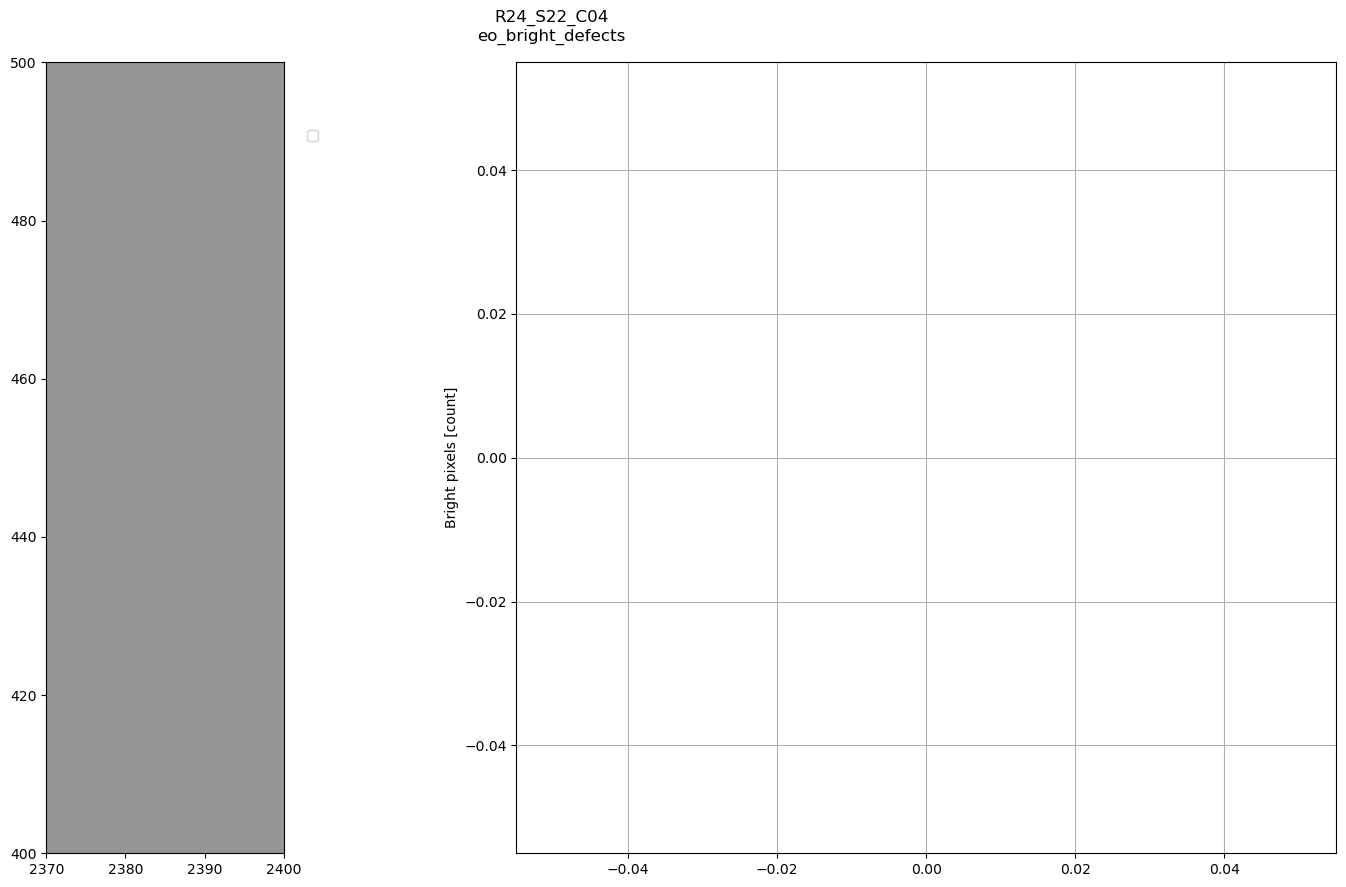

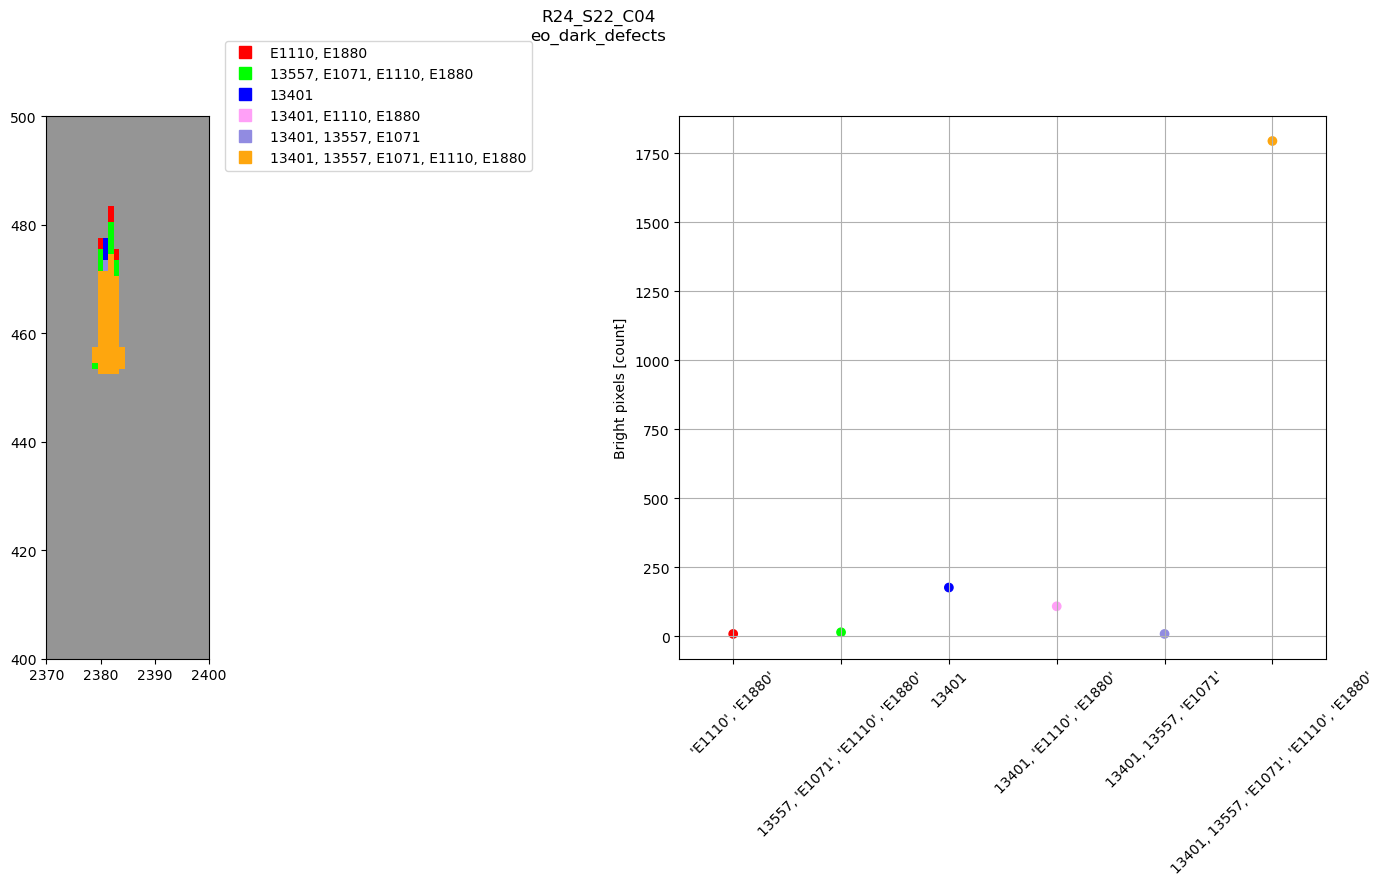

In [19]:
runList = [13401,13557,"E1071","E1110", "E1880"]
for defectTypeIter in range(2):
    
    for detector_number_var,ampName,xlim,ylim in zip(detector_numbers,segments,xlims,ylims):
        
        # maskMerger function here
        maskList = []
        maskArrayList = []
        mask = defectMaskComparison(detector_number_var)

        for run in runList:
            mask.setRun(run)
            mask.setDetectorObj(myu.det_names[detector_number_var])
            mask.setAmplifier(ampName)
            mask.applyMaskToImage(defect_names[defectTypeIter][0],defect_names[defectTypeIter][1])
            
            maskArrayList.append(mask.maskArray)
            maskList.append(mask)
            
        mask.combineMasks(maskArrayList,runList) # Combine the masks
    
        overlaps,n_overlaps = eo_stats(mask,amplifier=False,verbose=full_detector_verbose) # For the detector
        overlaps,n_overlaps = eo_stats(mask,amplifier=True,verbose=full_amplifier_verbose) # For the amplifier
        
        # Add figure here
    
        # mask.scaleMaskForMTV()
    
        # mask.adjustMaskValues(-1) # Need to add this call for the figure to work - ONLY WORKS WITH TWO UNIQUE MASKS

        # maskUniquenessFigure here
        
        fig,axs = plt.subplots(1,2,figsize=[16,9])
        fig.suptitle("{}_{}\n{}".format(mask.bay_slot,mask.segment,defect_names[defectTypeIter][0]))
    
        # Subplot of masked region of detector, on amp level
    
        plt.sca(axs[0])
        disp = afwDisplay.Display(fig)
        disp.setImageColormap('Greys')
        mycolors = format_mtv(disp,mask,axs[0])
        disp.mtv(mask.ampImage)
        leg_elements,mycolors2 = formatmtv2(disp,mask,axs[0],mycolors)
        axs[0].legend(handles=leg_elements,loc=(1.1,0.9))
        disp.show_colorbar(False)
        
        axs[0].set_ylim(ylim)
        axs[0].set_xlim(xlim)
        
        # Subplot of the changes over multiple different EO runs   
        runColorDict = getColorsRunPlot(disp,mask)
        plt.sca(axs[1])
        axs[1].scatter(np.arange(len(overlaps)),n_overlaps,color=mycolors2)
        format_runPlot(axs[1],overlaps,"Bright pixels [count]")
    
        # ax.set_title()
        fig.tight_layout()
        plt.savefig(figure_dir+"/{}_{}.jpg".format(mask.bay_slot,mask.segment),dpi=200)
    
        showAndClear()

# Debugging below

In [ ]:
collections = 'LSSTCam/raw/all,LSSTCam/calib'.split(",")
detector_num = 55

In [ ]:
for run in run_list:
    repo = "/repo/main" if run>13999 else "/repo/ir2"
    butler = rsu.makeButler(repo,collections)
    registry = rsu.makeRegistry(butler)
    for defectEntry in [defect_names[0]]:
        defect_path,defectDatasetType = defectEntry

        # Retrieve the eo_*_defect
        entry_collection = registry.queryCollections(f"*{defect_path}_{run}*",collectionTypes=daf_butler.CollectionType.CHAINED)
        kwargs = rsu.makeKwargs([run],defectDatasetType,detector_num,entry_collection)
        refs_defect_entry = list(registry.queryDatasets(**kwargs))
        entry_defect = butler.get(refs_defect_entry[-1])

        # Retrieve the merged defect mask
        merged_def_collection = registry.queryCollections(f"*/defects_{run}*",collectionTypes=daf_butler.CollectionType.CHAINED)
        merged_kwargs = rsu.makeKwargs([run],"defects",detector_num,merged_def_collection)
        refs_merged_defects = list(registry.queryDatasets(**kwargs))
        merged_defect = butler.get(refs_merged_defects[-1])
        # print(refs)